In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

plt.style.use(['dark_background'])

In [ ]:
data    =   pd.read_csv('2627/training_data.csv', index_col='id')
tournament  =   pd.read_csv('2627/tournament_data.csv', index_col='id')

In [ ]:
data    =   data.select_dtypes('double').astype('float16')

In [ ]:
tournament  =   tournament.select_dtypes('double').astype('float16')

In [ ]:
print(data.info())
print(tournament.info())

In [ ]:
x_train =   data.drop('target', axis=1)
y_train =   data.target

In [ ]:
from sklearn.decomposition import PCA

pca =   PCA(n_components=0.6)

x_train =   pd.DataFrame(pca.fit_transform(x_train), index=x_train.index)

In [ ]:
x_test  =   tournament.dropna().drop('target', axis=1)
y_test  =   tournament.dropna().target

In [ ]:
pca =   PCA(n_components=x_train.shape[1])
x_test =   pd.DataFrame(pca.fit_transform(x_test), index=x_test.index)

In [ ]:
from assets import regression_performance, prediction_graph, get_sklearn_regression

In [11]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor, 
    RandomForestRegressor, 
)
from sklearn.linear_model import (
    LinearRegression,
    BayesianRidge,
    RANSACRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

regressors   =   [
    #GradientBoostingRegressor, 
    HistGradientBoostingRegressor, 
    #RandomForestRegressor, 
    LinearRegression,
    BayesianRidge,
    # RANSACRegressor, 
    # KNeighborsRegressor, 
    MLPRegressor, 
    DecisionTreeRegressor
]

trained_regressors  =   get_sklearn_regression(regressors, x_train, y_train, x_test, y_test, graph=False, print_results=True)


Regressor: HistGradientBoostingRegressor
RMSE: 0.22
Performance Percentage: 0.50
Precision: 68.76
R2 Score Test = -0.001
MAE Test =  0.152

Regressor: LinearRegression
RMSE: 0.22
Performance Percentage: 0.50
Precision: 68.78
R2 Score Test = -0.001
MAE Test =  0.153

Regressor: BayesianRidge
RMSE: 0.22
Performance Percentage: 0.50
Precision: 68.76
R2 Score Test = -0.001
MAE Test =  0.152

Regressor: MLPRegressor
RMSE: 0.22
Performance Percentage: 0.47
Precision: 73.35
R2 Score Test = -0.003
MAE Test =  0.155

Regressor: DecisionTreeRegressor
RMSE: 0.33
Performance Percentage: 0.32
Precision: 70.62
R2 Score Test = -1.155
MAE Test =  0.244


In [12]:
best_regressor  =   sorted(trained_regressors, key=lambda x:np.sqrt(mean_squared_error(x.predict(x_test), y_test)))

In [13]:
# 27
from assets import bagging_regerssion 
preds   =   bagging_regerssion(best_regressor[0:2], x_train, y_train, x_test, y_test, return_preds=True)

Regressor: HistGradientBoostingRegressor
RMSE: 0.22
Performance Percentage: 0.50
Precision: 67.89
R2 Score Test = -0.000
MAE Test =  0.151
Regressor: BayesianRidge
RMSE: 0.22
Performance Percentage: 0.50
Precision: 68.57
R2 Score Test = -0.001
MAE Test =  0.152


In [14]:
from sklearn.ensemble import VotingRegressor

vr  =   VotingRegressor([(i.__class__.__name__, i) for i in best_regressor[:5]])
vr.fit(x_train, y_train)
pred=   vr.predict(x_test)

performance, rmse, precision    = regression_performance(pred, y_test.to_numpy(), print_results=True)
preds['VotingRegressor']    =   pred

RMSE: 0.23
Performance Percentage: 0.23
Precision: 67.67
R2 Score Test = -0.047
MAE Test =  0.167


In [15]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

adaboostreg = get_sklearn_regression([AdaBoostRegressor], x_train, y_train, x_test, y_test, graph=False, print_results=True)
preds['AdaBoostRegressor(DecisionTreeRegressor)']   =   adaboostreg[0].predict(x_test)
abr =   AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators=5).fit(x_train, y_train)
print('\nAdaBoostRegressor, base estimator: ', 'LinearRegression')
_   =   regression_performance(abr.predict(x_test), y_test, print_results=True)
preds['AdaBoostRegressor(LinearRegression)']    =   abr.predict(x_test)


Regressor: AdaBoostRegressor
RMSE: 0.22
Performance Percentage: 0.50
Precision: 66.00
R2 Score Test = -0.000
MAE Test =  0.152

AdaBoostRegressor, base estimator:  LinearRegression
RMSE: 0.22
Performance Percentage: 0.50
Precision: 68.70
R2 Score Test = -0.001
MAE Test =  0.153


In [16]:
preds['Target']  =   y_test.values

In [17]:
preds.corr()

,HistGradientBoostingRegressor,BayesianRidge,VotingRegressor,AdaBoostRegressor(DecisionTreeRegressor),AdaBoostRegressor(LinearRegression),Target
HistGradientBoostingRegressor,1.000000,0.758899,0.127423,0.691904,0.740914,0.002048
BayesianRidge,0.758899,1.000000,0.129200,0.595326,0.980808,0.001313
VotingRegressor,0.127423,0.129200,1.000000,0.093359,0.128258,-0.000630
AdaBoostRegressor(DecisionTreeRegressor),0.691904,0.595326,0.093359,1.000000,0.592640,-0.000281
AdaBoostRegressor(LinearRegression),0.740914,0.980808,0.128258,0.592640,1.000000,0.000806
Target,0.002048,0.001313,-0.000630,-0.000281,0.000806,1.000000


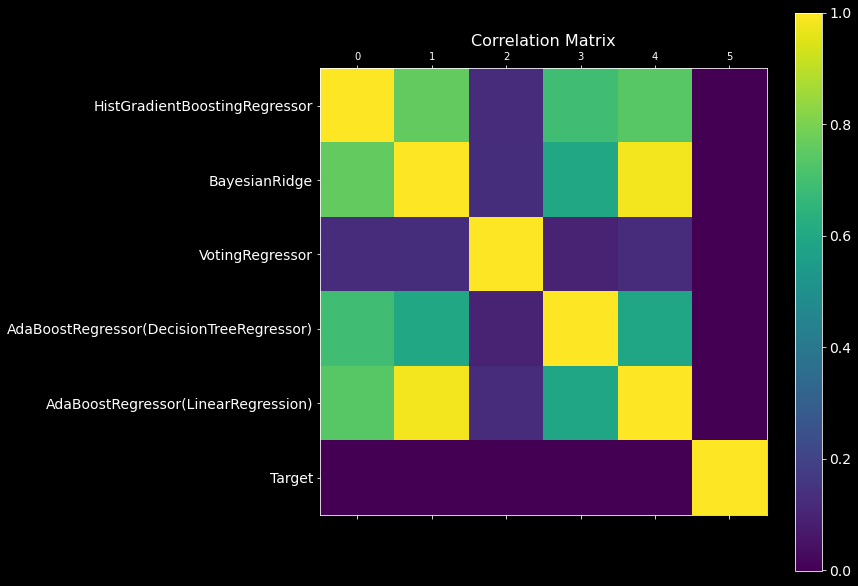

In [44]:
from assets import plot_corr_matrix
plot_corr_matrix(preds)

In [45]:
%store preds x_test x_train y_test y_train trained_regressors

Stored 'preds' (DataFrame)
Stored 'x_test' (DataFrame)
Stored 'x_train' (DataFrame)
Stored 'y_test' (Series)
Stored 'y_train' (Series)
Stored 'trained_regressors' (list)
